In [1]:
import os
import mne
import numpy as np
from mne.time_frequency import tfr_multitaper
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.optim as optim
import torch.nn as nn

In [2]:
def interpolate(raw):
    # Extract data from raw object (returns an array of shape [n_channels, n_times])
    raw_data = raw.get_data()

    # Replace very large values with NaNs
    raw_data[np.abs(raw_data) > 1e2] = np.nan

    # Get indices of NaNs
    nan_indices = np.where(np.isnan(raw_data))
    nan_indices = np.vstack(nan_indices).transpose()

    # Hypothesis: Punctual NaNs
    for channel, timepoint in nan_indices:
        # Check if the NaN is not at the first or last timepoint to avoid indexing errors
        if timepoint > 0 and timepoint < raw_data.shape[1] - 1:
            # Get value before and after the NaN point
            before = raw_data[channel, timepoint - 1]
            after = raw_data[channel, timepoint + 1]
            
            # Interpolate by averaging the values before and after
            raw_data[channel, timepoint] = (before + after) / 2

    # Check if any NaNs remain after interpolation
    remaining_nan_indices = np.where(np.isnan(raw_data))
    any_nan = len(remaining_nan_indices[0]) != 0
    if any_nan:
        raise ValueError("Data still contain NaNs after interpolation")

    # Set the modified data back to the raw object
    raw._data = raw_data

    return raw


In [3]:
def load_and_extract_intervals(file_path):
    # Load the data (adjust the file path and format)
    raw = mne.io.read_raw_fif(file_path, preload=True)

    problematic_channels = ['TIME_STAMP_s', 'TIME_STAMP_ms', 'COUNTER', 'INTERPOLATED', 
                            'HighBitFlex', 'RAW_CQ', 'BATTERY', 'MarkerIndex', 'MarkerType', 
                            'MarkerValueInt', 'MARKER_HARDWARE', 'CQ_Cz', 'CQ_Fz', 'CQ_Fp1', 'CQ_F7',
                            'CQ_F3', 'CQ_FC1', 'CQ_C3', 'CQ_FC5', 'CQ_FT9', 'CQ_T7', 'CQ_CP5', 
                            'CQ_CP1', 'CQ_P3', 'CQ_P7', 'CQ_PO9', 'CQ_O1', 'CQ_Pz', 'CQ_Oz', 'CQ_O2',
                            'CQ_PO10', 'CQ_P8', 'CQ_P4', 'CQ_CP2', 'CQ_CP6', 'CQ_T8', 'CQ_FT10',
                            'CQ_FC6', 'CQ_C4', 'CQ_FC2', 'CQ_F4', 'CQ_F8', 'CQ_Fp2', 'CQ_OVERALL', 
                            'CQ_CMS', 'CQ_DRL']
    
    # Pick only EEG channels and exclude problematic ones
    raw_eeg_clean = raw.pick_types(eeg=True, exclude=problematic_channels)
    
    # Apply bandpass filter
    raw_eeg_clean.filter(l_freq=0.5, h_freq=40.0)
    
    # Apply notch filter to remove powerline noise (e.g., 50 Hz for Europe, 60 Hz for the US)
    raw_eeg_clean.notch_filter(freqs=[60], picks='eeg')  # Use 60 Hz for US-based systems
    
    # Set a standard EEG montage
    montage = mne.channels.make_standard_montage('standard_1020')
    raw_eeg_clean.set_montage(montage)

    # Interpolate bad channels
    raw_eeg_clean.interpolate_bads()

    # Re-reference data to average
    raw_eeg_clean.set_eeg_reference('average', projection=True)

    # Set up ICA
    ica = mne.preprocessing.ICA(n_components=20, random_state=97, max_iter=800)
    
    # Fit ICA on the raw data
    ica.fit(raw_eeg_clean)
    
    # Plot ICA components to identify artifacts
    ica.plot_components()
    
    # Detect and remove eye-blink related components
    ica.exclude = [0]  # Example component index for eye blinks
    
    # Apply ICA
    raw_eeg_clean = ica.apply(raw_eeg_clean)

    # Segment length in seconds
    segment_length = 2 
    
    # Create fixed length events for epochs
    events = mne.make_fixed_length_events(raw_eeg_clean, duration=segment_length)
    
    # Create epochs
    epochs = mne.Epochs(raw_eeg_clean, events, tmin=-0.2, tmax=segment_length, baseline=(None, 0), preload=True)

    # To make equal number of epochs, find the minimum number of epochs
    min_epochs = 38  # Set desired number of epochs (e.g., 100)
    
    # Randomly select epochs to ensure an equal number
    if len(epochs) != min_epochs:
        indices = np.random.choice(len(epochs), size=min_epochs, replace=False)
        epochs = epochs[indices]

    # Return the data as a numpy array
    array = np.array(epochs.get_data())
    return array


In [4]:
import json
import pandas as pd

# Load JSON data
with open('splits_subject_identification.json', 'r') as f:
    data = json.load(f)

# Get the length of the longest list
max_length = max(len(v) for v in data.values())

# Pad lists with None to make all lists the same length
for key, value in data.items():
    if len(value) < max_length:
        data[key].extend([None] * (max_length - len(value)))

# Convert to DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df)


                                                 train  \
0    {'spotify_track_id': '06s6aloy62vytl3MnT6gfl',...   
1    {'spotify_track_id': '0h9fnCSnbUgOEgibnQByFv',...   
2    {'spotify_track_id': '1iArQTuOzxvrtniGmkyy92',...   
3    {'spotify_track_id': '3A9vIxzGBjEfqmDK7H9exS',...   
4    {'spotify_track_id': '39kHMfF3dBMZMbOtoit1XF',...   
..                                                 ...   
237  {'spotify_track_id': '0pVfvpMSFsabyuydMihDi1',...   
238  {'spotify_track_id': '3spdoTYpuCpmq19tuD0bOe',...   
239  {'spotify_track_id': '0FB5ILDICqwK6xj7W1RP9u',...   
240  {'spotify_track_id': '4qFLzh0BSi0KpPYbTWHENQ',...   
241  {'spotify_track_id': '1PAEeikWsmjY5pB3hbuF7G',...   

                                             val_trial val_subject  \
0    {'spotify_track_id': '4JJ5zGKnb1IpERyBrfmb1y',...        None   
1    {'spotify_track_id': '36qZIsik56PiT7HnM58e8g',...        None   
2    {'spotify_track_id': '6Q4HcsWQpfXHvIZTRbTIuT',...        None   
3    {'spotify_track_id

In [5]:
df['train'][0]['subject_id']

23

In [6]:
df['test_trial'][0]

{'spotify_track_id': None,
 'song_title': None,
 'session_type': 'other',
 'id': 7571232268,
 'song_author': None}

In [7]:
file_names=[]
all_labels=[]

for i in range (0,len(df['train'])):
    id=df['train'][i]['id']
    label=df['train'][i]['subject_id']
    file_names.append(str(id)+'_eeg.fif')
    all_labels.append(label)


Opening raw data file raw/train/3784258358_eeg.fif...


Isotrak not found
    Range : 9361 ... 19600 =     73.133 ...   153.125 secs
Ready.
Reading 0 ... 10239  =      0.000 ...    79.992 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain des

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/g5/b9cy28ks44x_v0t6r5r41ptw0000gn/T/ipykernel_27173/3395448066.py:28: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_eeg_clean.interpolate_bads()


Fitting ICA took 7.4s.


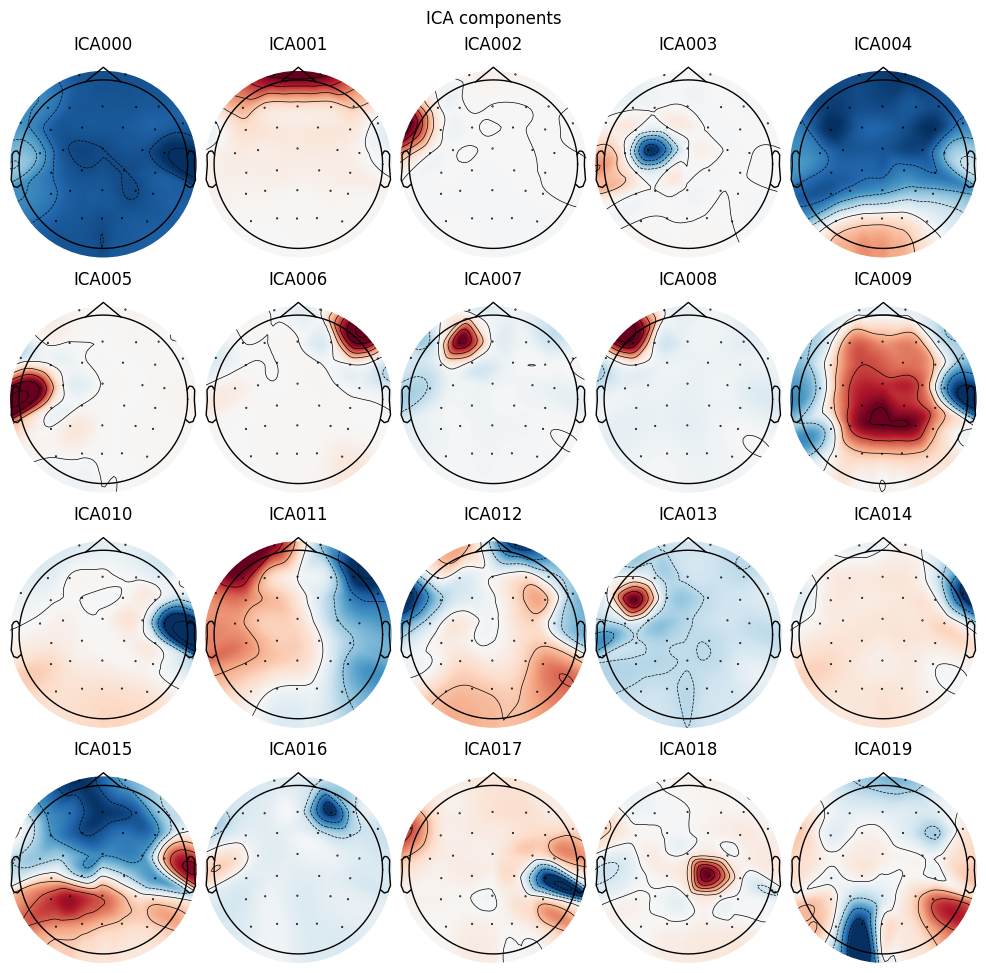

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components
Not setting metadata
40 matching events found
Setting baseline interval to [-0.203125, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 40 events and 283 original time points ...
2 bad epochs dropped
Opening raw data file raw/train/2395445698_eeg.fif...
Isotrak not found
    Range : 20939 ... 31178 =    163.586 ...   243.578 secs
Ready.
Reading 0 ... 10239  =      0.000 ...    79.992 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.

/var/folders/g5/b9cy28ks44x_v0t6r5r41ptw0000gn/T/ipykernel_27173/3395448066.py:66: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  array = np.array(epochs.get_data())
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/g5/b9cy28ks44x_v0t6r5r41ptw0000gn/T/ipykernel_27173/3395448066.py:28: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_eeg_clean.interpolate_bads()


Fitting ICA took 6.5s.


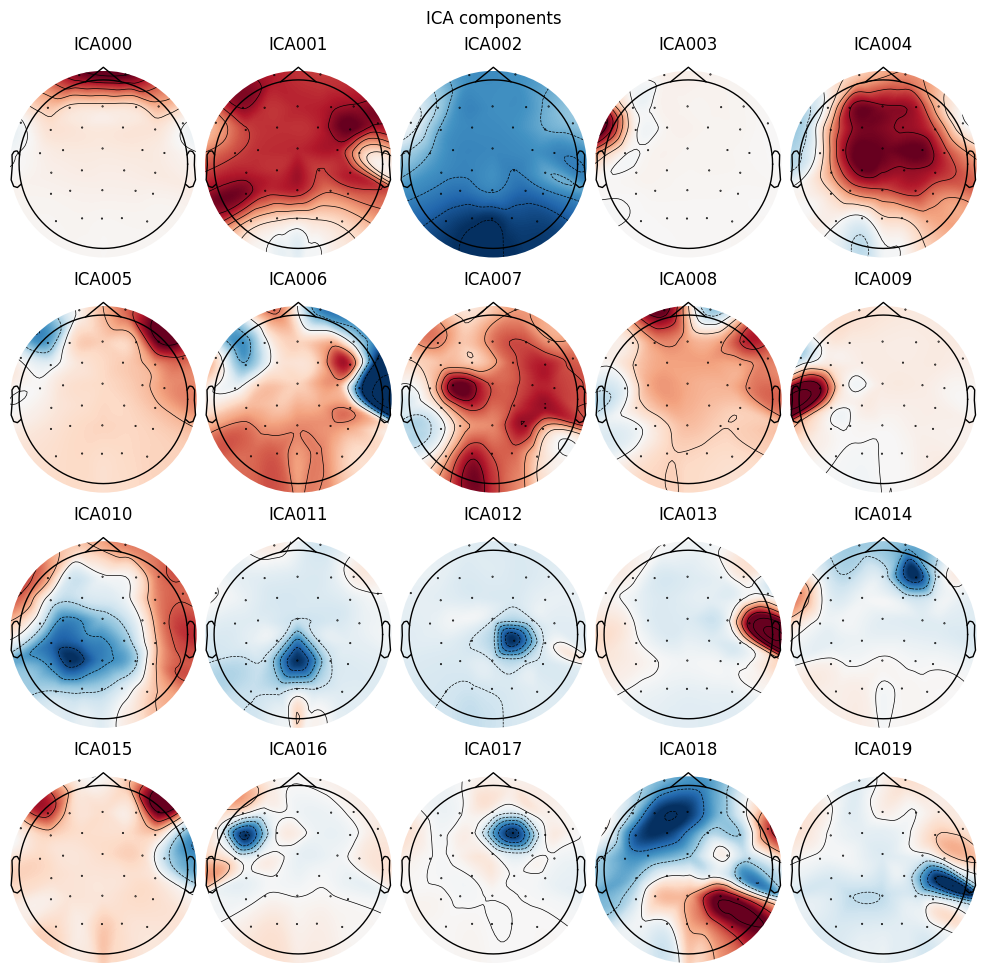

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components
Not setting metadata
40 matching events found
Setting baseline interval to [-0.203125, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 40 events and 283 original time points ...
2 bad epochs dropped
Opening raw data file raw/train/3049220457_eeg.fif...
Isotrak not found
    Range : 32286 ... 42525 =    252.234 ...   332.227 secs
Ready.
Reading 0 ... 10239  =      0.000 ...    79.992 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.

/var/folders/g5/b9cy28ks44x_v0t6r5r41ptw0000gn/T/ipykernel_27173/3395448066.py:66: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  array = np.array(epochs.get_data())
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/g5/b9cy28ks44x_v0t6r5r41ptw0000gn/T/ipykernel_27173/3395448066.py:28: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_eeg_clean.interpolate_bads()


Fitting ICA took 6.2s.


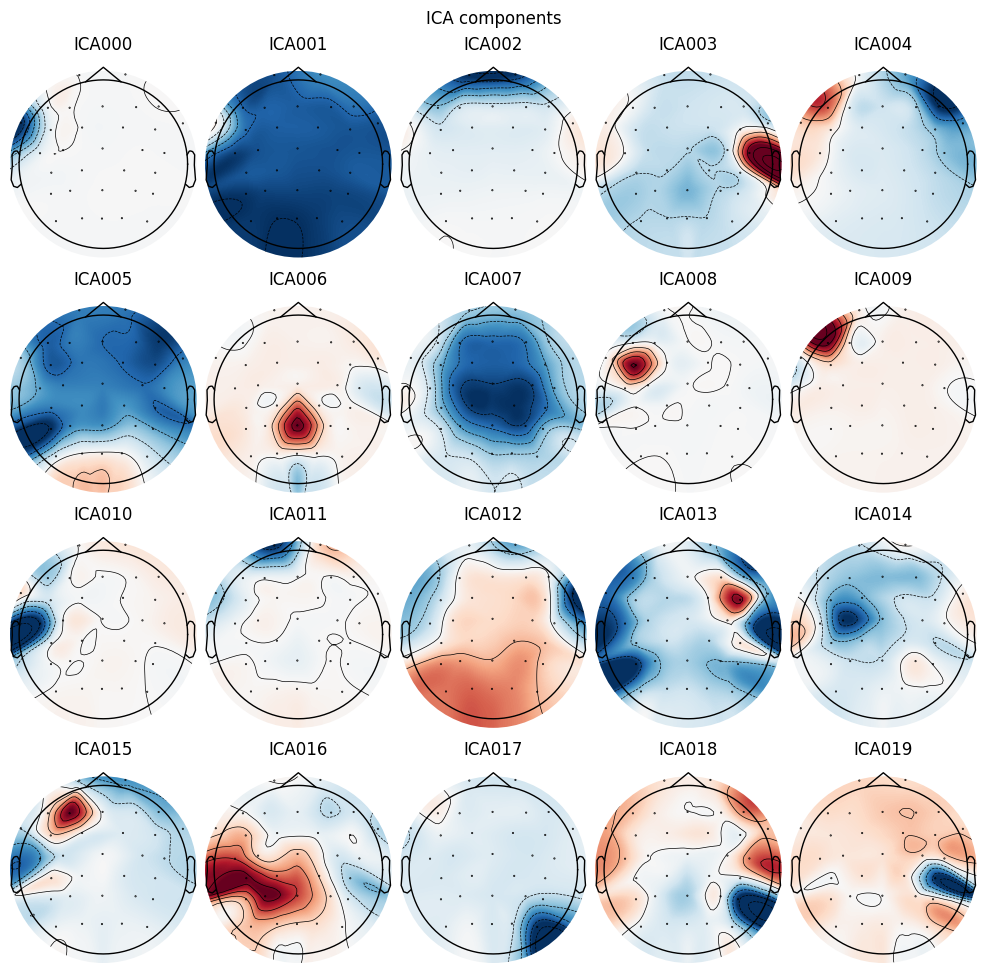

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components
Not setting metadata
40 matching events found
Setting baseline interval to [-0.203125, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 40 events and 283 original time points ...
2 bad epochs dropped
Opening raw data file raw/train/2667905835_eeg.fif...
Isotrak not found
    Range : 44256 ... 54495 =    345.750 ...   425.742 secs
Ready.
Reading 0 ... 10239  =      0.000 ...    79.992 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.

/var/folders/g5/b9cy28ks44x_v0t6r5r41ptw0000gn/T/ipykernel_27173/3395448066.py:66: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  array = np.array(epochs.get_data())
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 845 samples (6.602 s)

Setting channel interpolation method to {'eeg': 'spline'}.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/g5/b9cy28ks44x_v0t6r5r41ptw0000gn/T/ipykernel_27173/3395448066.py:28: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_eeg_clean.interpolate_bads()


Fitting ICA took 7.1s.


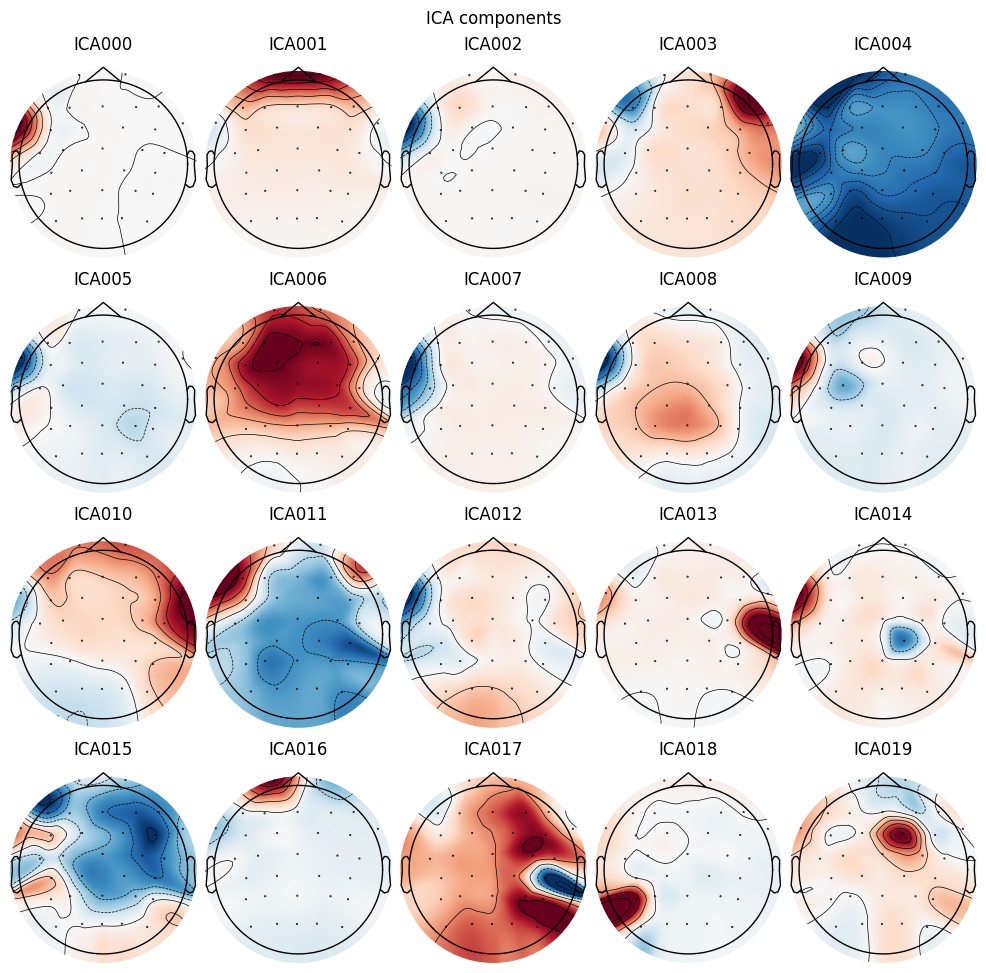

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components
Not setting metadata
40 matching events found
Setting baseline interval to [-0.203125, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 40 events and 283 original time points ...
2 bad epochs dropped
Opening raw data file raw/train/1281311748_eeg.fif...
Isotrak not found
    Range : 56100 ... 66339 =    438.281 ...   518.273 secs
Ready.
Reading 0 ... 10239  =      0.000 ...    79.992 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.

/var/folders/g5/b9cy28ks44x_v0t6r5r41ptw0000gn/T/ipykernel_27173/3395448066.py:66: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  array = np.array(epochs.get_data())
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/g5/b9cy28ks44x_v0t6r5r41ptw0000gn/T/ipykernel_27173/3395448066.py:28: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_eeg_clean.interpolate_bads()


Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 6.2s.


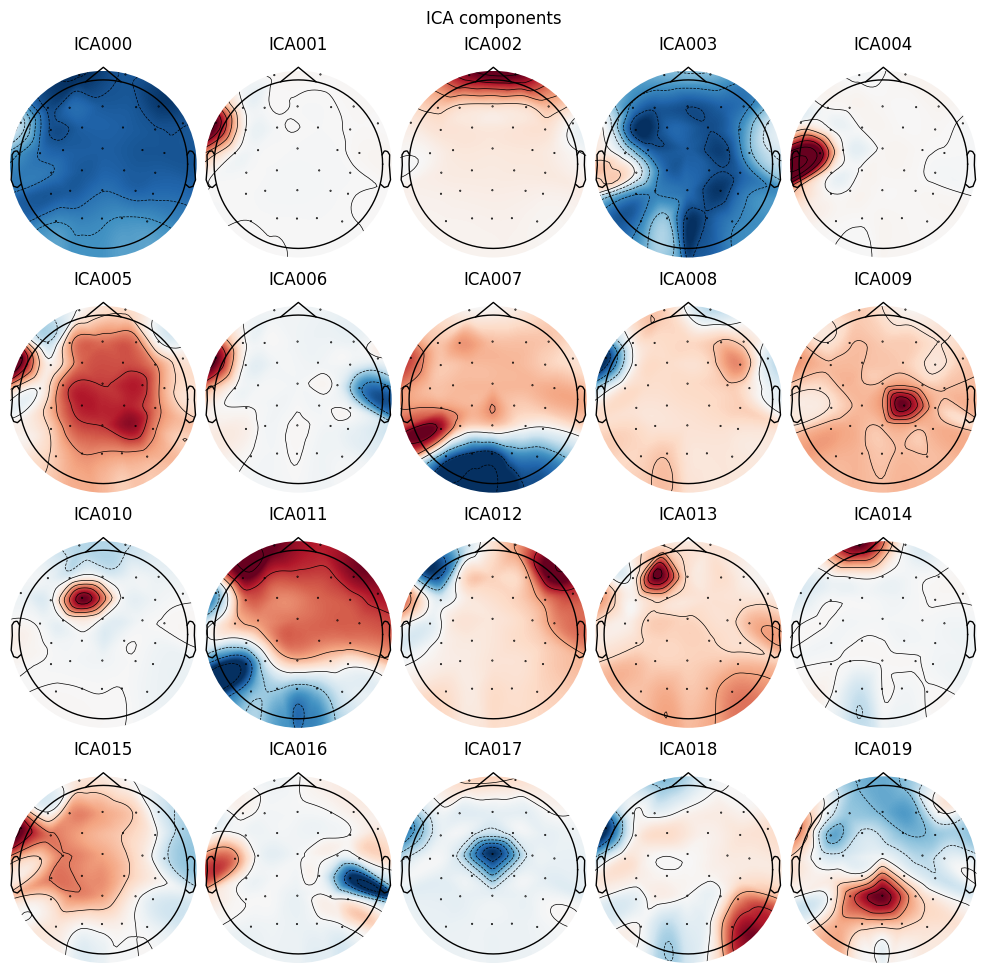

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components
Not setting metadata
40 matching events found
Setting baseline interval to [-0.203125, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 40 events and 283 original time points ...
2 bad epochs dropped
Opening raw data file raw/train/2608559859_eeg.fif...
Isotrak not found
    Range : 8958 ... 19756 =     69.984 ...   154.344 secs
Ready.
Reading 0 ... 10798  =      0.000 ...    84.359 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0

/var/folders/g5/b9cy28ks44x_v0t6r5r41ptw0000gn/T/ipykernel_27173/3395448066.py:66: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  array = np.array(epochs.get_data())


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 845 samples (6.602 s)

Setting channel interpolation method to {'eeg': 'spline'}.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/g5/b9cy28ks44x_v0t6r5r41ptw0000gn/T/ipykernel_27173/3395448066.py:28: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_eeg_clean.interpolate_bads()


Fitting ICA took 4.2s.


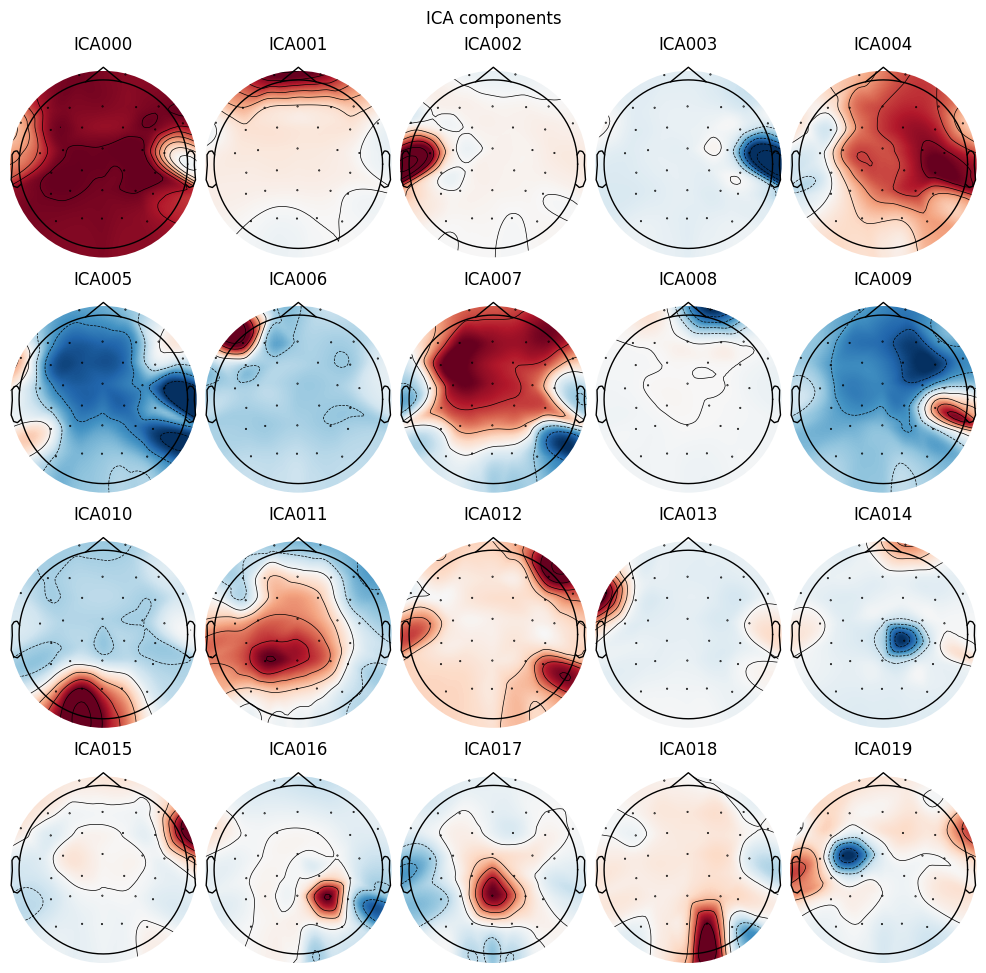

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components
Not setting metadata
42 matching events found
Setting baseline interval to [-0.203125, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 42 events and 283 original time points ...
1 bad epochs dropped
Opening raw data file raw/train/2596145110_eeg.fif...
Isotrak not found
    Range : 24142 ... 35123 =    188.609 ...   274.398 secs
Ready.
Reading 0 ... 10981  =      0.000 ...    85.789 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.

/var/folders/g5/b9cy28ks44x_v0t6r5r41ptw0000gn/T/ipykernel_27173/3395448066.py:66: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  array = np.array(epochs.get_data())
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 845 samples (6.602 s)

Setting channel interpolation method to {'eeg': 'spline'}.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/g5/b9cy28ks44x_v0t6r5r41ptw0000gn/T/ipykernel_27173/3395448066.py:28: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_eeg_clean.interpolate_bads()


Fitting ICA took 7.1s.


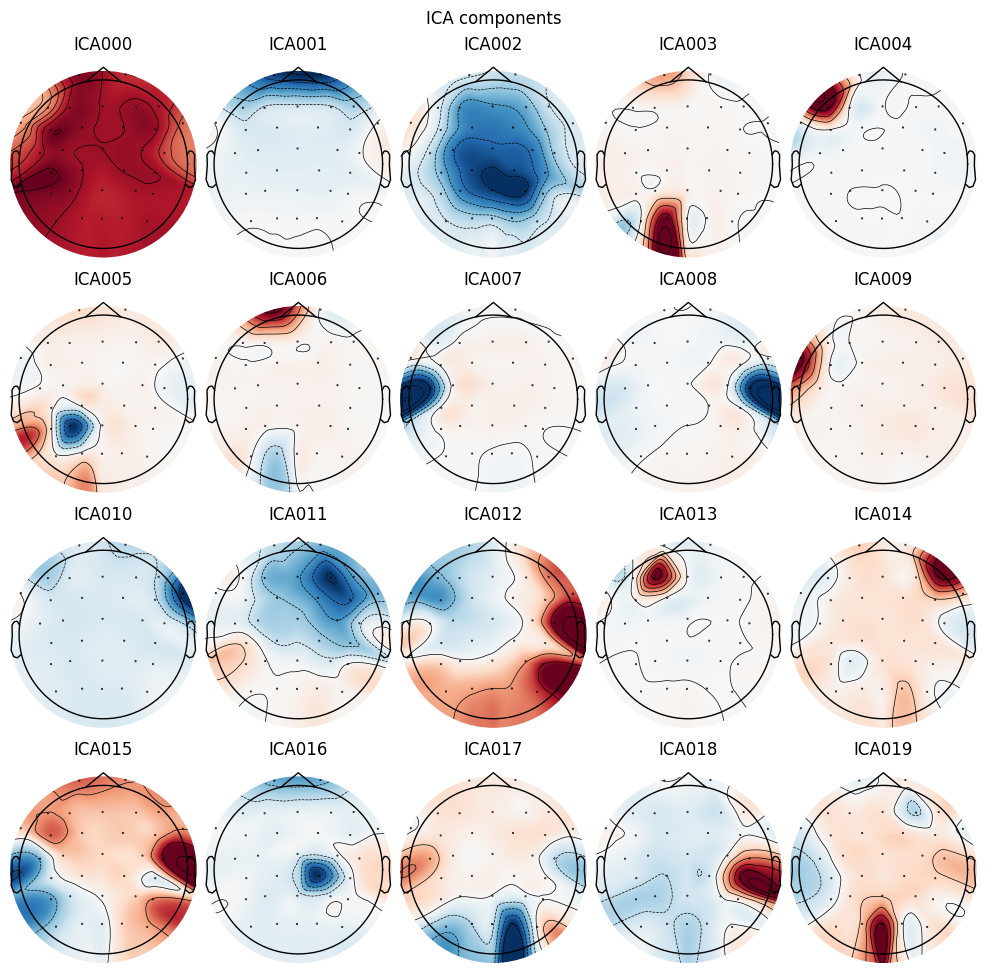

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components
Not setting metadata
42 matching events found
Setting baseline interval to [-0.203125, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 42 events and 283 original time points ...
1 bad epochs dropped
Opening raw data file raw/train/8309820898_eeg.fif...
Isotrak not found
    Range : 38490 ... 50006 =    300.703 ...   390.672 secs
Ready.
Reading 0 ... 11516  =      0.000 ...    89.969 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.

/var/folders/g5/b9cy28ks44x_v0t6r5r41ptw0000gn/T/ipykernel_27173/3395448066.py:66: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  array = np.array(epochs.get_data())


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 845 samples (6.602 s)

Setting channel interpolation method to {'eeg': 'spline'}.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/g5/b9cy28ks44x_v0t6r5r41ptw0000gn/T/ipykernel_27173/3395448066.py:28: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_eeg_clean.interpolate_bads()


Fitting ICA took 6.6s.


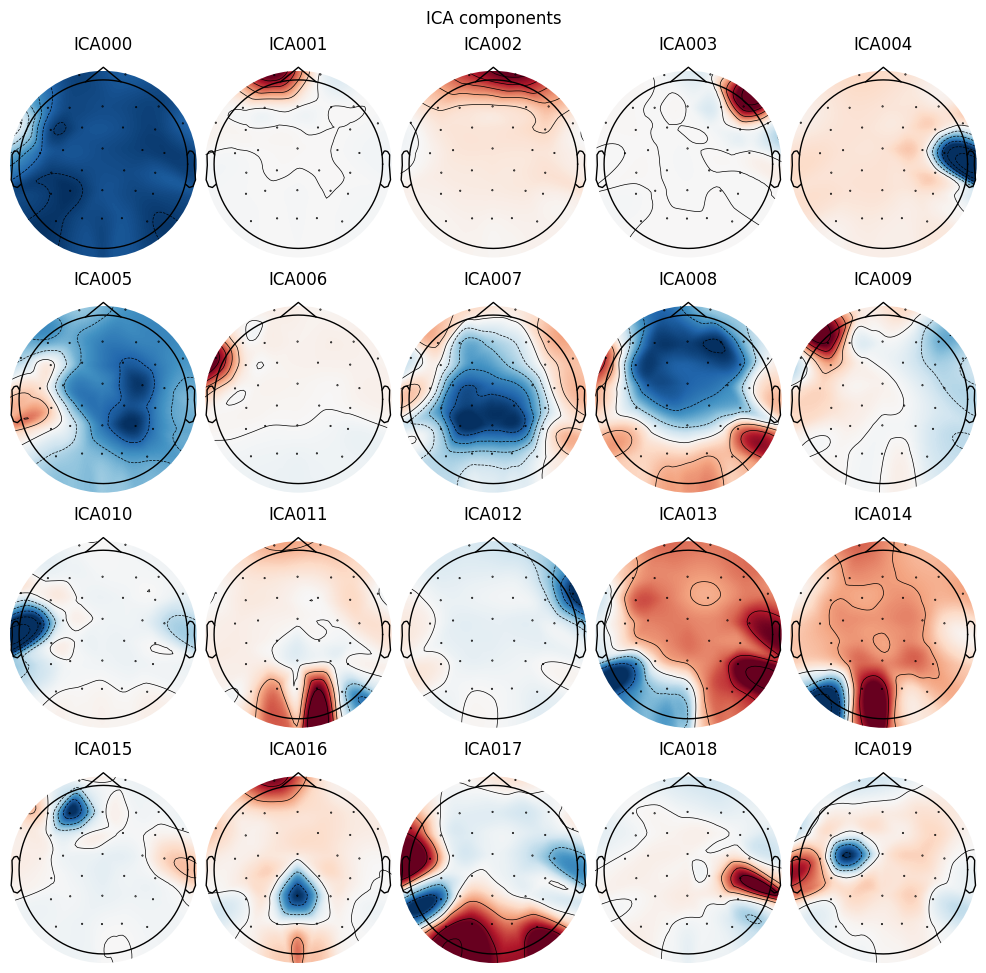

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components
Not setting metadata
44 matching events found
Setting baseline interval to [-0.203125, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 44 events and 283 original time points ...
1 bad epochs dropped
Opening raw data file raw/train/7497445780_eeg.fif...
Isotrak not found
    Range : 53973 ... 65252 =    421.664 ...   509.781 secs
Ready.
Reading 0 ... 11279  =      0.000 ...    88.117 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.

/var/folders/g5/b9cy28ks44x_v0t6r5r41ptw0000gn/T/ipykernel_27173/3395448066.py:66: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  array = np.array(epochs.get_data())


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 845 samples (6.602 s)

Setting channel interpolation method to {'eeg': 'spline'}.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
/var/folders/g5/b9cy28ks44x_v0t6r5r41ptw0000gn/T/ipykernel_27173/3395448066.py:28: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_eeg_clean.interpolate_bads()


Fitting ICA took 6.7s.


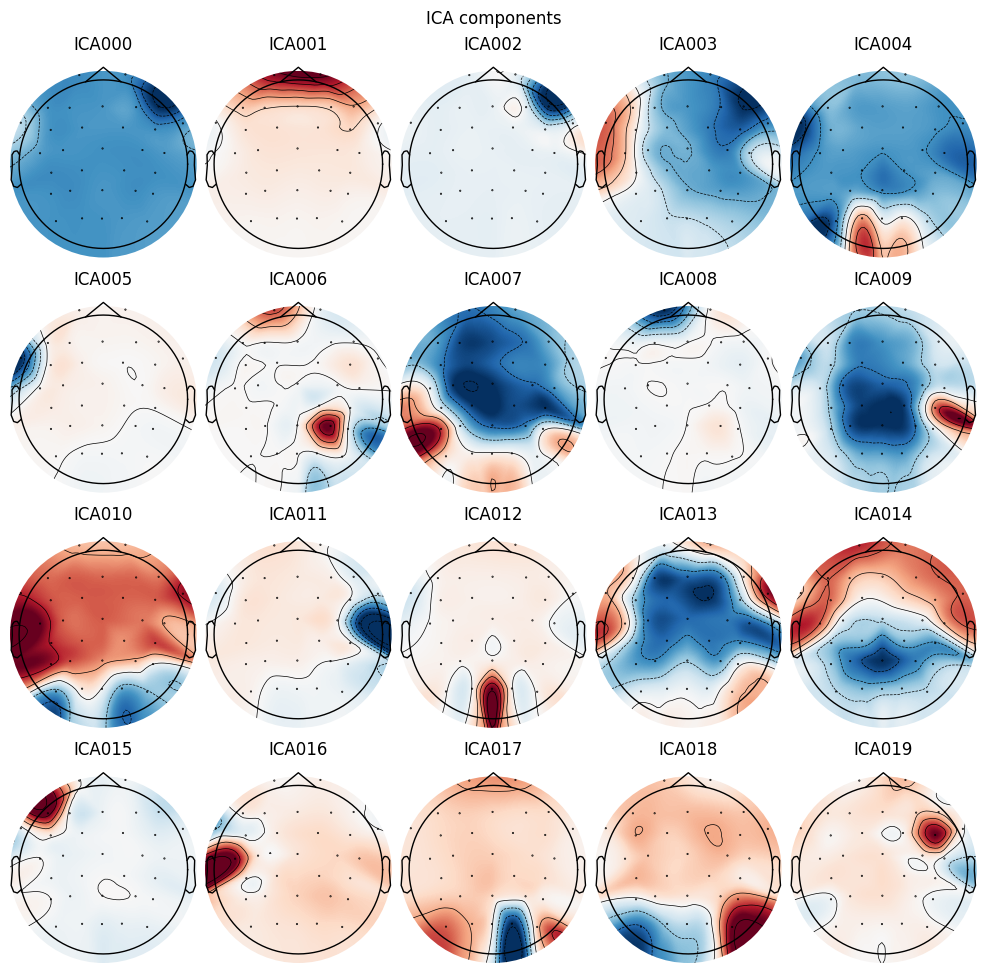

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components
Not setting metadata
44 matching events found
Setting baseline interval to [-0.203125, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 44 events and 283 original time points ...
1 bad epochs dropped
Opening raw data file raw/train/6438333572_eeg.fif...
Isotrak not found
    Range : 68621 ... 80349 =    536.102 ...   627.727 secs
Ready.
Reading 0 ... 11728  =      0.000 ...    91.625 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.

/var/folders/g5/b9cy28ks44x_v0t6r5r41ptw0000gn/T/ipykernel_27173/3395448066.py:66: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  array = np.array(epochs.get_data())
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting channel interpolation method to {'eeg': 'spline'}.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components


/var/folders/g5/b9cy28ks44x_v0t6r5r41ptw0000gn/T/ipykernel_27173/3395448066.py:28: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw_eeg_clean.interpolate_bads()


Fitting ICA took 6.8s.


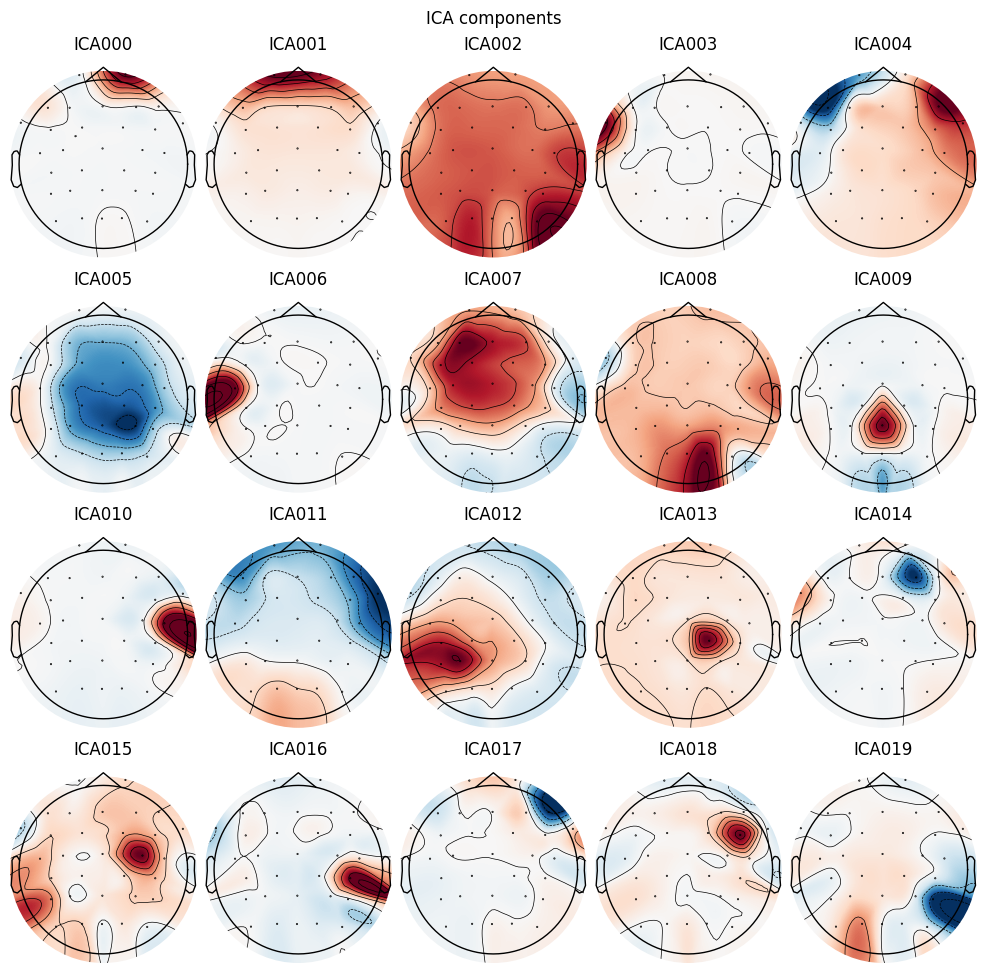

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 32 PCA components
Not setting metadata
45 matching events found
Setting baseline interval to [-0.203125, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 45 events and 283 original time points ...
1 bad epochs dropped


/var/folders/g5/b9cy28ks44x_v0t6r5r41ptw0000gn/T/ipykernel_27173/3395448066.py:66: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  array = np.array(epochs.get_data())


In [8]:
# Initialize lists to hold data and labels
all_data = []

src_train_folder='raw/train'

for file in file_names:
    file_path=os.path.join(src_train_folder, file)
    temp = load_and_extract_intervals(file_path)    
    all_data.append(temp)

# all_data = np.array(all_data)
# all_labels = np.array(all_labels)

In [9]:
all_data=np.array(all_data)
all_labels=np.array(all_labels)

In [1]:
all_labels = all_labels.reshape(all_labels.shape[0], 1)

NameError: name 'all_labels' is not defined

In [14]:
scaler = StandardScaler()
all_data = scaler.fit_transform(all_data.reshape(-1, all_data.shape[-1])).reshape(all_data.shape)

In [15]:
indices = np.arange(all_data.shape[0])
np.random.shuffle(indices)

all_data = all_data[indices]
all_labels = all_labels[indices]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(all_data, all_labels, test_size=0.2, random_state=42)

In [17]:
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_eegnet(input_shape, num_classes):
    input_layer = layers.Input(shape=input_shape)
    
    # First convolutional block
    x = layers.Conv2D(32, (1, 64), padding='same', activation='elu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (2, 1), padding='same', activation='elu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(1, 2))(x)  # Changed pool size to (1, 2)
    
    # Second convolutional block
    x = layers.Conv2D(64, (1, 32), padding='same', activation='elu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (2, 1), padding='same', activation='elu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(1, 2))(x)  # Changed pool size to (1, 2)
    
    # Third convolutional block
    x = layers.Conv2D(128, (1, 16), padding='same', activation='elu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (2, 1), padding='same', activation='elu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(1, 2))(x)  # Changed pool size to (1, 2)
    
    # Fully connected layer
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='elu')(x)
    x = layers.Dropout(0.5)(x)
    
    # Adjust output layer for binary classification
    output_layer = layers.Dense(1, activation='sigmoid')(x)  # Change to a single output for binary classification
    
    model = models.Model(inputs=input_layer, outputs=output_layer)
    
    return model


In [ ]:
# Define input shape and create model
input_shape = (all_data.shape[1], all_data.shape[2], all_data.shape[3]) 
num_classes=23
model = create_eegnet(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(all_data, all_labels, batch_size=3, epochs=5, validation_split=0.2)


Epoch 1/2


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/losses/losses.py:22: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(2, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)
